In [1]:
# Libraries 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import datetime as dt
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as smm
import copy as cp
import importlib

import self_defined_functions as ft

In [2]:
holi_dict_type, holi_dict_len = ft.get_holiday_dict()
typhoon_date = pd.read_excel( 'Typhoon_date.xlsx' )['日期']
typhoon_date = [date.to_pydatetime() for date in typhoon_date ]

In [3]:
transCnt_dict = ft.get_trCnt()

# 2Way ANOVA of different holiday

In [4]:
# Set 
WORKDAYS = []
WEEKENDS = []
TRADI = ['春節','端午','中秋']
NATION = ['雙十', '二二八', '元旦', '清明', '勞動']

In [5]:
dates = []
years = []
months = []
days = []
trans_cnts = []
is_typhoons = []
day_types = []
holi_types = []
holi_lens = []
is_CNYEs = []
is_NYEs = []

In [6]:
for key in transCnt_dict.keys() : 
    # dates 
    dates.append( key ) 

    # year 
    years.append( key.year ) 

    # month
    months.append( key.month ) 

    # day 
    days.append( key.day )

    # trans_cnt 
    trans_cnts.append( transCnt_dict[key] ) 

    # is_typhoon
    is_typhoons.append( key in typhoon_date ) 

    # day_type
    if key in holi_dict_type.keys() : 
        if holi_dict_type[key] in TRADI : 
            day_types.append( 'traditional')
        elif holi_dict_type[key] in NATION :
            day_types.append( 'National' )
        else :
            day_types.append( 'NewYearEve' )
    else :
        if key.weekday() in range( 0, 5 ) : 
            day_types.append( 'weekday' ) 
        else :
            day_types.append( 'weekend' )

    # holi_type
    if key in holi_dict_type.keys() : 
        holi_types.append( holi_dict_type[key] ) 
    else :
        if key.weekday() in range( 0, 5 ) : 
            holi_types.append( 'weekday' ) 
        else :
            holi_types.append( 'weekend' )

    # is_CNYE
    if key not in holi_dict_type.keys() : 
        is_CNYEs.append( False ) 
        continue 
    if holi_dict_type[key] == '春節' :
        try : 
            if holi_dict_type[key+dt.timedelta( days = -1 )] == '春節' : 
                is_CNYEs.append( False ) 
        except :
            is_CNYEs.append( True )

    # is_NYE
    if key.month == 12 and key.day == 31 :
        is_NYEs.append( True )
    else :
        is_NYEs.append( False )
    

In [7]:
# holi_len
acc = 0 
startIndex = 0 
endIndex = 0
currentType = holi_types[0]
for i in range( len( holi_types ) ) :
    if holi_types[i] == currentType : 
        endIndex += 1 
        acc += 1 
    else : 
        for j in range( startIndex, endIndex ) :
            holi_lens.append( acc )
        acc = 0
        startIndex = endIndex 
        currentType = holi_types[i]
        endIndex += 1 

for i in range( startIndex, endIndex ) : 
    holi_lens.append( acc )

[2,
 2,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 0,
 5,
 5,
 5,
 5,
 5,
 5,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 4,
 4,
 4,
 4,
 4,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 1,
 1,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 4,
 4,
 4,
 4,
 4,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 1,
 1,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 4,
 4,
 4,


In [8]:
print( len( holi_lens ) )
print( len( holi_types ) )

6328
6330


In [9]:
pd.DataFrame( { 'type' : holi_types, 'len' : holi_lens } ) 

ValueError: All arrays must be of the same length

In [ ]:
set( holi_dict_type.values() )

{'中秋', '二二八', '元旦', '勞動', '春節', '清明', '端午', '雙十'}

In [ ]:
CNT = []
DATE = []
YEAR = []
HOLI_TYPE = []
HOLI_LEN = []
HOLI = []
for key in transCnt_dict.keys() : 
    # Date 
    DATE.append( key )
    YEAR.append( key.year )
    # Cnt  
    CNT.append( transCnt_dict[key] ) 
    # Type

    if key in holi_dict_type.keys() : 
        if holi_dict_type[key] in TRADI : 
            HOLI_TYPE.append( 'Traditional')
        elif holi_dict_type[key] in NATION :
            HOLI_TYPE.append( 'National' )
        else :
            HOLI_TYPE.append( 'NewYearEve' )
    else :
        if key.weekday() in range( 0, 5 ) : 
            HOLI_TYPE.append( 'Weekday' ) 
        else :
            HOLI_TYPE.append( 'Weekend' )

        

In [ ]:
ANOVA_df = pd.DataFrame ( { 'Date':DATE, 
                            'Transport_Count':CNT,
                            'Day_Type':HOLI_TYPE } )

In [ ]:
results = smf.ols('Transport_Count~ C(Day_Type)', data=ANOVA_df).fit()
aov_table = sms.anova_lm(results, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
C(Day_Type),9.023848e+12,3.0,212.082118,4.354979e-131
Residual,8.972132e+13,6326.0,NaN,NaN


In [ ]:
resid_dict = {}
for i in range( len( ANOVA_df ) ) :
    resid_dict[ANOVA_df['Date'][i].to_pydatetime()] = results.resid[i]

In [ ]:
stat, p = stats.shapiro( results.resid )
print( f'p = {p:.4f}' )

p = 0.0000


c:\Users\PuSung\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


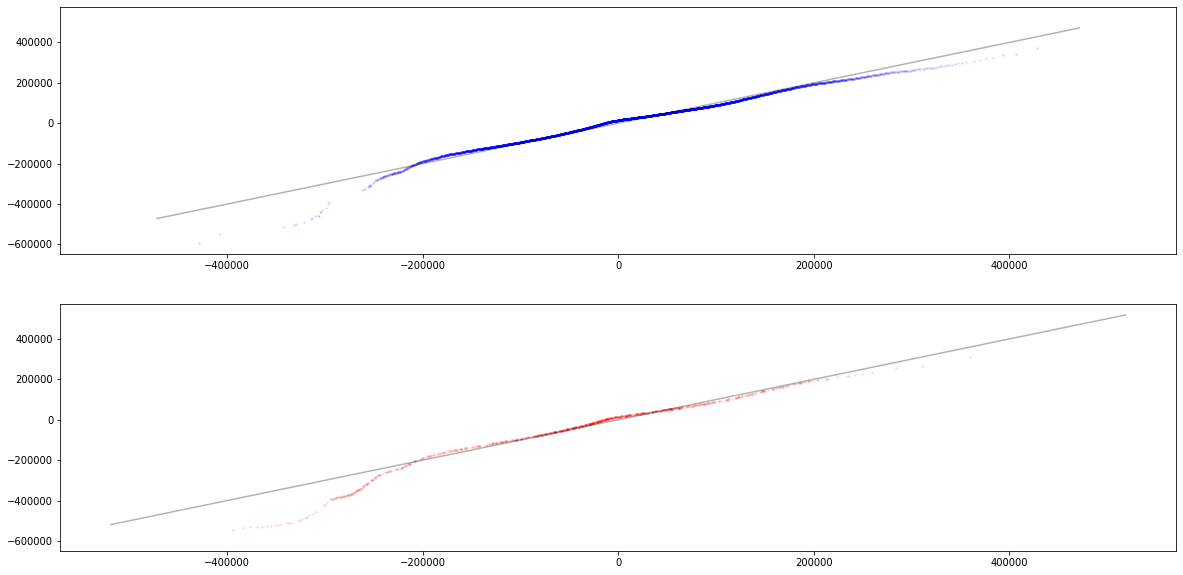

In [ ]:
ft.self_qqplot( resid_dict, 2020 )

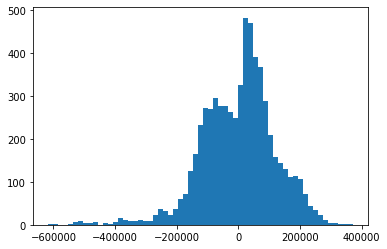

In [ ]:
_ = plt.hist( results.resid, bins='auto' )

In [ ]:
import seaborn as sns

In [ ]:
AFTER_2020 = np.array( YEAR ) > 2020

In [ ]:
sns_df = pd.DataFrame( {'After_2020' : AFTER_2020, 'cnt' : CNT, 'resid':results.resid } )

Text(0, 0.5, 'Value')

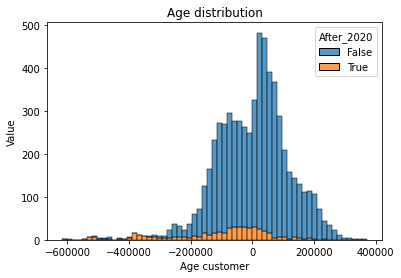

In [ ]:
sns.histplot(data=sns_df, x="resid", hue="After_2020", multiple="stack")
plt.title("Age distribution")
plt.xlabel("Age customer")
plt.ylabel("Value")

# 2 way ANOVA of different length of weekends